In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Aug  2 10:02:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    47W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!git clone https://github.com/Vela-Yang/vela_SR.git SR

fatal: destination path 'SR' already exists and is not an empty directory.


In [3]:
!python ./SR/gdrive.py 1l3hCk-auHrckMCwMDQEMxAzuUxG4wIcR velaSR.zip
!unzip velaSR.zip

In [4]:
# !pip3 install torch torchvision torchaudio

import torch
import torchvision
from SR.models import AVS3Filter
from SR.dataset import VelaDataset
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
from tqdm.notebook import tqdm


# 是否有GPU加速
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == "cuda":
    num_workers = 4
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False
print(device)

cuda


In [5]:
# 加载网络模型
model = AVS3Filter().to(device)


# 损失函数
loss_fun = torch.nn.MSELoss().to(device)
losses = []
losses_test = []

# 数据集加载
train_set = VelaDataset(root="./velaSR/", number_of_files=19140, size_of_crop= 256, subset="training")
test_set = VelaDataset(root="./velaSR/", number_of_files=19140, size_of_crop= 256, subset="testing")

In [7]:
# 优化器
optimizer = torch.optim.AdamW(model.parameters())
# 批大小
batch_size = 16

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory
)
test_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size= int(batch_size),
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
    pin_memory=pin_memory
)


In [8]:
from torch.cuda.amp import autocast
scaler = torch.cuda.amp.GradScaler()

# 训练函数
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (y, y_lr) in enumerate(train_loader):
        with autocast():
          y, y_lr = y.to(device), y_lr.to(device)
          output = model(y_lr/ 255)
          loss = loss_fun(output, y/ 255)
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        #loss.backward()
        #optimizer.step()
        # 展示训练状态
        if batch_idx % log_interval == 0:
            print(
                f"迭代次数: {epoch} [{batch_idx * len(y_lr)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\t训练损失: {loss.item():.6f}")
        # 更新状态栏
        pbar.update(pbar_update)
        # 记录训练损失
        losses.append(loss.item())


# 测试
def test(model, epoch):
    model.eval()
    for y, y_lr in test_loader:
        with autocast():
          y, y_lr = y.to(device), y_lr.to(device)
          output = model(y_lr / 255)
          loss = loss_fun(output, y / 255)
        losses_test.append(loss.item())
        # 更新状态栏
        pbar.update(pbar_update)
    print(f"\n迭代次数 {epoch}\t测试损失: {loss.item():.6f}")


迭代次数: 1 [0/11480 (0%)]	训练损失: 1.001552
迭代次数: 1 [1120/11480 (10%)]	训练损失: 0.833350
迭代次数: 1 [2240/11480 (19%)]	训练损失: 0.713006
迭代次数: 1 [3360/11480 (29%)]	训练损失: 0.605479
迭代次数: 1 [4480/11480 (39%)]	训练损失: 0.508202
迭代次数: 1 [5600/11480 (49%)]	训练损失: 0.429704
迭代次数: 1 [6720/11480 (58%)]	训练损失: 0.360006
迭代次数: 1 [7840/11480 (68%)]	训练损失: 0.295229
迭代次数: 1 [8960/11480 (78%)]	训练损失: 0.244983
迭代次数: 1 [10080/11480 (88%)]	训练损失: 0.196789
迭代次数: 1 [11200/11480 (97%)]	训练损失: 0.159663

迭代次数 1	测试损失: 0.151157
迭代次数: 2 [0/11480 (0%)]	训练损失: 0.153635
迭代次数: 2 [1120/11480 (10%)]	训练损失: 0.120322
迭代次数: 2 [2240/11480 (19%)]	训练损失: 0.096046
迭代次数: 2 [3360/11480 (29%)]	训练损失: 0.075475
迭代次数: 2 [4480/11480 (39%)]	训练损失: 0.059778
迭代次数: 2 [5600/11480 (49%)]	训练损失: 0.045231
迭代次数: 2 [6720/11480 (58%)]	训练损失: 0.035414
迭代次数: 2 [7840/11480 (68%)]	训练损失: 0.026092
迭代次数: 2 [8960/11480 (78%)]	训练损失: 0.019701
迭代次数: 2 [10080/11480 (88%)]	训练损失: 0.014633
迭代次数: 2 [11200/11480 (97%)]	训练损失: 0.011340

迭代次数 2	测试损失: 0.008555
迭代次数: 3 [0/11480 (0%)]	训练损失: 0.010

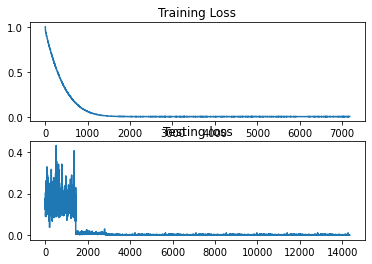

In [9]:

n_epoch = 10
log_interval = 70
pbar_update = 1 / (len(train_loader) + len(test_loader))

with tqdm(total=n_epoch) as pbar:   
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)

# 展示训练损失与准确率
plt.subplot(2, 1, 1)
plt.plot(losses);
plt.title("Training Loss");
plt.subplot(2, 1, 2)
plt.plot(losses_test);
plt.title("Testing loss");



In [10]:
torch.save(model.state_dict(), '1.pth')
torch.save(model, '1.pkl') 

In [11]:
def clear_overflow(tensor):
  zero_value = torch.tensor([0]).to("cpu", torch.float)
  neg_clear = torch.heaviside(tensor, zero_value)
  result_tensor = tensor * neg_clear + 0.01
  overflow = result_tensor - 255
  pos_clear = torch.heaviside(overflow, zero_value) * overflow
  result_tensor = result_tensor - pos_clear
  result_tensor = result_tensor.floor()
  result_tensor = result_tensor.squeeze(0)
  result_tensor = result_tensor.to("cpu", torch.uint8)
  return result_tensor

In [15]:

from torchvision.io import read_image, ImageReadMode, write_jpeg
torch.cuda.empty_cache()
model = model.to("cpu")
# 输入图像
im = read_image('30.jpg', mode=ImageReadMode.GRAY)
im = im.to("cpu", torch.float) / 255
# 网络输出
with torch.no_grad():
  out = model(im.unsqueeze(0)) * 255
  out = clear_overflow(out)
write_jpeg(out, '3.jpg')

In [13]:
from google.colab import files
files.download('1.pth')
files.download('1.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>